In [1]:
# Mount Drive files
from google.colab import drive
drive.mount('/content/drive', readonly=False, force_remount=True)

Mounted at /content/drive


In [2]:
!git clone https://github.com/facebookresearch/fastText.git
!cd fastText
!pip install fastText -q

Cloning into 'fastText'...
remote: Enumerating objects: 3998, done.
remote: Counting objects: 100% (1057/1057), done.
remote: Compressing objects: 100% (197/197), done.
remote: Total 3998 (delta 922), reused 889 (delta 855), pack-reused 2941
Receiving objects: 100% (3998/3998), 8.30 MiB | 39.15 MiB/s, done.
Resolving deltas: 100% (2529/2529), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
!git clone https://github.com/artetxem/vecmap.git

Cloning into 'vecmap'...
remote: Enumerating objects: 104, done.
remote: Total 104 (delta 0), reused 0 (delta 0), pack-reused 104
Receiving objects: 100% (104/104), 72.59 KiB | 2.90 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [4]:
!ls

drive  fastText  sample_data  vecmap


In [5]:
import fasttext.util
import os
import re
import matplotlib.pyplot as plt

from gensim.models import Word2Vec
from typing import List
import string

# documentation: https://radimrehurek.com/gensim/models/word2vec.html

In [6]:
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/Machine Translation and Multilingualism/MT Final Project/Data/"
MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/Machine Translation and Multilingualism/MT Final Project/Model/"
FASTTEXT_PATH = os.path.join(DATA_PATH, "fasttext/")
EMBEDDING_PATH = os.path.join(DATA_PATH, "embedding/")
TRAIN_TEST_PATH = os.path.join(DATA_PATH, "train_test/")

In [7]:
# reference: https://opus.nlpl.eu/results/id&en/corpus-result-table
CORPUS_EN_ID_PATH = os.path.join(DATA_PATH, "corpus/en-id/")

In [8]:
W2V_MODEL_EN_EMB_PATH = os.path.join(MODEL_PATH,'english_word2vec_model.bin')
W2V_MODEL_ID_EMB_PATH = os.path.join(MODEL_PATH,'indonesian_word2vec_model.bin')

In [9]:
W2V_EN_EMB_PATH = os.path.join(EMBEDDING_PATH,'w2v.embeddings.en')
W2V_ID_EMB_PATH = os.path.join(EMBEDDING_PATH,'w2v.embeddings.id')

PRETRAINED_FT_EN_EMB_PATH = os.path.join(EMBEDDING_PATH,'pretrained-fasttext.embeddings.en')
PRETRAINED_FT_ID_EMB_PATH = os.path.join(EMBEDDING_PATH,'pretrained-fasttext.embeddings.id')

FT_EN_EMB_PATH = os.path.join(EMBEDDING_PATH,'fasttext.embeddings.en')
FT_ID_EMB_PATH = os.path.join(EMBEDDING_PATH,'fasttext.embeddings.id')

In [10]:
SEMISUP_27_MAPPED_ENID_EN_EMB_PATH = os.path.join(EMBEDDING_PATH,'semisupervised_mapped_embeddings.en-id.27.en')
SEMISUP_27_MAPPED_ENID_ID_EMB_PATH = os.path.join(EMBEDDING_PATH,'semisupervised_mapped_embeddings.en-id.27.id')

SEMISUP_1500_MAPPED_ENID_EN_EMB_PATH = os.path.join(EMBEDDING_PATH,'semisupervised_mapped_embeddings.en-id.1500.en')
SEMISUP_1500_MAPPED_ENID_ID_EMB_PATH = os.path.join(EMBEDDING_PATH,'semisupervised_mapped_embeddings.en-id.1500.id')

SEMISUP_NUMERAL_MAPPED_ENID_EN_EMB_PATH = os.path.join(EMBEDDING_PATH,'semisupervised_mapped_embeddings.en-id.num.en')
SEMISUP_NUMERAL_MAPPED_ENID_ID_EMB_PATH = os.path.join(EMBEDDING_PATH,'semisupervised_mapped_embeddings.en-id.num.id')

UNSUP_MAPPED_ENID_EN_EMB_PATH = os.path.join(EMBEDDING_PATH,'unsupervised_mapped_embeddings.en-id.en')
UNSUP_MAPPED_ENID_ID_EMB_PATH = os.path.join(EMBEDDING_PATH,'unsupervised_mapped_embeddings.en-id.id')

In [11]:
EN_ID_TRAIN_NUMERAL_DICT_PATH = os.path.join(TRAIN_TEST_PATH,'train_numeral.en-id.dict')

EN_ID_FULL_ANNOTATED_DICT_PATH = os.path.join(DATA_PATH,'DICT/PARTITION/DICT_REVISED_FULL.txt')

EN_ID_TRAIN_27_DICT_PATH = os.path.join(TRAIN_TEST_PATH,'train_27.en-id.dict')
EN_ID_TRAIN_1500_DICT_PATH = os.path.join(TRAIN_TEST_PATH,'train_1500.en-id.dict')
EN_ID_TEST_DICT_PATH = os.path.join(TRAIN_TEST_PATH,'test.en-id.dict')

In [12]:
!ls "$DATA_PATH"

corpus	DICT  embedding  fasttext  train_test


# Word2Vec

## 1. Create Embedding

**Description from the vecmap paper:**
<br>
The embeddings were trained with the word2vec toolkit with CBOW and negative sampling (Mikolov et al., 2013b)

In [ ]:
en_text = []
id_text = []

# english corpus
with open(os.path.join(CORPUS_EN_ID_PATH,'News-Commentary.en-id.en')) as f:
  en_text += [sent.strip() for sent in f.readlines()] # parallel data (en-id)
with open(os.path.join(CORPUS_EN_ID_PATH,'wikimedia.en')) as f:
  en_text += [sent.strip() for sent in f.readlines()] # mono data (en-id)

with open(os.path.join(CORPUS_EN_ID_PATH,'News-Commentary.en-id.id')) as f:
  id_text += [sent.strip() for sent in f.readlines()] # parallel data (en-id)
with open(os.path.join(CORPUS_EN_ID_PATH,'wikimedia.id')) as f:
  id_text += [sent.strip() for sent in f.readlines()] # mono data (en-id)

In [ ]:
# Define the parameters for training
vector_size = 300  # Dimensionality of the word vectors
sg = 0  # Use CBOW model

# Train word embeddings for each language
def train_word2vec_model(text: List[List[str]], model_file):
    model = Word2Vec(text, vector_size=vector_size, sg=sg, epochs=5, negative=10, sample=1e-5)
    model.save(model_file)

def preprocess_text(text_list: List[List[str]]):
    # Define translation table to remove punctuation
    translator = str.maketrans('', '', string.punctuation)

    # List to store preprocessed text
    preprocessed_text = []

    # Iterate over each text in the list
    for text in text_list:
        # Remove punctuation and convert to lowercase
        preprocessed_text.append(text.translate(translator).lower().split())

    return preprocessed_text

In [ ]:
en_text[0]

'Closing the Financial Services’ Accessibility Gap'

In [ ]:
# train_word2vec_model(preprocess_text(en_text), W2V_MODEL_EN_EMB_PATH)
# train_word2vec_model(preprocess_text(id_text), W2V_MODEL_ID_EMB_PATH)

In [ ]:
!wc "/content/drive/MyDrive/Colab Notebooks/Machine Translation and Multilingualism/MT Final Project/Data/corpus/en-id/News-Commentary.en-id.en"
!wc "/content/drive/MyDrive/Colab Notebooks/Machine Translation and Multilingualism/MT Final Project/Data/corpus/en-id/wikimedia.en"
!wc "/content/drive/MyDrive/Colab Notebooks/Machine Translation and Multilingualism/MT Final Project/Data/corpus/en-id/News-Commentary.en-id.id"
!wc "/content/drive/MyDrive/Colab Notebooks/Machine Translation and Multilingualism/MT Final Project/Data/corpus/en-id/wikimedia.id"

  18054  376873 2460800 /content/drive/MyDrive/Colab Notebooks/Machine Translation and Multilingualism/MT Final Project/Data/corpus/en-id/News-Commentary.en-id.en
  18987630  431427780 2766103752 /content/drive/MyDrive/Colab Notebooks/Machine Translation and Multilingualism/MT Final Project/Data/corpus/en-id/wikimedia.en
  18054  373842 2847797 /content/drive/MyDrive/Colab Notebooks/Machine Translation and Multilingualism/MT Final Project/Data/corpus/en-id/News-Commentary.en-id.id
  453709  8426567 60583872 /content/drive/MyDrive/Colab Notebooks/Machine Translation and Multilingualism/MT Final Project/Data/corpus/en-id/wikimedia.id


In [ ]:
len(en_text), len(id_text)

(19005684, 471763)


In [ ]:
!ls "$ID_EMB_PATH"

'/content/drive/MyDrive/Colab Notebooks/Machine Translation and Multilingualism/MT Final Project/Data/embedding/embeddings.id'


In [ ]:
# Load the model
en_loaded_model = Word2Vec.load(W2V_MODEL_EN_EMB_PATH)

# Access the embeddings
en_word_vectors = en_loaded_model.wv
# Save the word vectors to a text file
# en_word_vectors.save_word2vec_format(W2V_EN_EMB_PATH, binary=False)

In [ ]:
# Load the model
id_loaded_model = Word2Vec.load(W2V_MODEL_ID_EMB_PATH)

# Access the embeddings
id_word_vectors = id_loaded_model.wv
# Save the word vectors to a text file
# id_word_vectors.save_word2vec_format(W2V_ID_EMB_PATH, binary=False)

## 2. Create the Seed Dictionary

In [ ]:
en_loaded_model = Word2Vec.load(W2V_MODEL_EN_EMB_PATH)
id_loaded_model = Word2Vec.load(W2V_MODEL_ID_EMB_PATH)

In [ ]:
# Get the vocabulary list
en_vocab = list(en_loaded_model.wv.index_to_key)
id_vocab = list(id_loaded_model.wv.index_to_key)

In [ ]:
# with open(os.path.join(EMBEDDING_PATH, "vocab.en"), "w") as f:
#   for vocab in en_vocab:
#     f.write(vocab + "\n")

# with open(os.path.join(EMBEDDING_PATH, "vocab.id"), "w") as f:
#   for vocab in id_vocab:
#     f.write(vocab + "\n")

In [ ]:
en_vocab[-20:]

['diaspora',
 'handled',
 'suspicion',
 'unparalleled',
 'leastdeveloped',
 'sdgs’',
 'agroecology',
 'residential',
 'hoping',
 'supplychain',
 'aiib',
 'rival',
 'switzerland',
 'portrayed',
 'project’s',
 'determination',
 'megacities',
 'citystate',
 'everyday',
 'ppp']

### 2.1. Numeral Dictionary

**Description from the vecmap paper: <br>**
In addition to that, we explored using automatically generated dictionaries as a shortcut to practical unsupervised learning. For that purpose, we created numeral dictionaries, consisting of words matching the [0-9]+ regular expression in both vocabularies (e.g. 1-1, 2-2, 3-3, 1992-1992, etc.).

In [ ]:
NUMERAL_PATTERN = re.compile(r"^[0-9]+$")

In [ ]:
def subset_values(list1, list2):
    return [x for x in list1 if x in list2]

In [ ]:
numerals_en = [vocab for vocab in en_vocab if NUMERAL_PATTERN.match(vocab)]
numerals_id = [vocab for vocab in id_vocab if NUMERAL_PATTERN.match(vocab)]

numerals_en = sorted(numerals_en)
numerals_id = sorted(numerals_id)
numerals_en_id = subset_values(numerals_en, numerals_id)

In [ ]:
with open(EN_ID_TRAIN_NUMERAL_DICT_PATH, "w") as f:
  for number in numerals_en_id:
    f.write(number + " " + number + "\n")

### 2.2. Word Dictionary

In [ ]:
with open(EN_ID_FULL_ANNOTATED_DICT_PATH) as f:
  lines = [line.lower().strip() for line in f.readlines()]
  lines = [line for line in lines if len(line.split()) == 2]

In [ ]:
lines[:5]

['prevention pencegahan',
 'hotel hotel',
 'level tingkat',
 'harvest panen',
 'need kebutuhan']

In [ ]:
new_lines = []
# check if the words are inside the corpus
for idx, line in enumerate(lines):
  en_word, id_word = line.split()
  if en_word not in en_vocab:
    print(idx, line)
    continue
  if id_word not in id_vocab:
    print(idx, line)
    continue
  new_lines.append(line)

lines = new_lines

82 dissonance disonansi
86 phase-out penghapusan
230 refinancing refinancing
349 riesman riesman
374 dononor donor
433 kampala kampala
495 reallocation realokasi
500 mabruka mabruka
645 filariasis filariasis
668 stigmatization stigmatisasi
690 spillovers limpahan
796 superficiality kedangkalan
797 typhoid tipus
804 autocrat otokrat
859 ventilator ventilator
871 hydrofluorocarbon hidrofluorokarbon
930 radiotherapy radioterapi
1025 malpractice malpraktik
1041 transmissibility transmisibilitas
1111 trade-off pertukaran
1119 bonanza bonanza
1149 collegiality kolegialitas
1177 terawatt terawatt
1238 sprayer penyemprot
1274 argumen argumen
1356 fax faks
1415 financialization finansialisasi
1434 affordability keterjangkauan
1502 spillover limpahan
1566 crony kroni
1623 barometer barometer
1632 male laki-laki
1665 ﻿return kembali
1670 troposphere troposfer
1741 sophistication kecanggihan
1873 dictum diktum
1955 vitriol vitriol
1964 onchocerciasis onchocerciasis
2026 trachoma trachoma
2035 lite

In [ ]:
import random

# Set the random seed
random.seed(42)  # You can choose any integer value as the seed

# Shuffle the list randomly
random.shuffle(lines)

size_1 = 27
size_2 = 660
size_3 = 1500

list_1 = lines[:size_1]
list_2 = lines[size_1:size_1+size_2]
list_3 = lines[size_1+size_2:]

In [ ]:
len(list_1), len(list_2), len(list_3)

(27, 660, 1500)

In [ ]:
# with open(EN_ID_TRAIN_27_DICT_PATH, "w") as f:
#   for line in list_1:
#     f.write(line + "\n")

# with open(EN_ID_TRAIN_1500_DICT_PATH, "w") as f:
#   for line in list_3:
#     f.write(line + "\n")

# with open(EN_ID_TEST_DICT_PATH, "w") as f:
#   for line in list_2:
#     f.write(line + "\n")

## 3. Create the Mapping

**Description from the vecmap paper: <br>**
`SRC.EMB` and `TRG.EMB` refer to the input monolingual embeddings, which should be in the word2vec text format, whereas `SRC_MAPPED.EMB` and `TRG_MAPPED.EMB` refer to the output cross-lingual embeddings. The training dictionary `TRAIN.DICT`, if any, should be given as a text file with one entry per line (source word + whitespace + target word).

### 3.1. Indonesia

In [ ]:
!head "$EN_EMB_PATH"

1177848 300
the -0.10382084 -0.914218 1.2491294 -0.6194455 -0.045288444 0.39569455 0.09676611 -1.1764559 0.2574808 0.55093217 0.0063004955 -0.26524845 0.33607486 0.69308996 1.2110039 -0.32514426 -0.08027092 -0.1774437 -0.5292771 -0.52346367 0.48555955 0.72258854 -0.4234364 0.69485074 0.49135122 0.000396541 -0.38865402 -0.75937444 1.3104523 -0.80889237 -0.12047575 -0.6216029 -0.82422334 0.5803111 0.5496512 -0.9829513 -0.84743047 0.5550051 0.65249765 0.62440974 0.15339032 -0.15946825 0.19400792 0.5641259 0.105750866 0.15764952 -0.58489937 0.6364048 -0.056938786 -0.16794921 0.039187934 0.1942936 0.9249231 -0.24683549 0.10034426 0.16810545 -0.59250146 0.2560454 0.19273964 0.24153142 -0.29837552 -0.061818674 1.6994259 0.5623049 1.2038783 0.21463111 0.26329032 0.91535306 0.15293303 -1.50071 -0.27817506 -0.52991664 1.2532029 1.4205375 -0.080667235 -0.30408978 0.27094588 0.009687093 0.5018447 -0.266374 1.1074479 1.3587897 -0.06723149 0.03863973 0.12482113 0.46673486 -0.70368016 0.67557865 -1.4

In [ ]:
# !python3 "vecmap/map_embeddings.py" --unsupervised "$W2V_EN_EMB_PATH" "$W2V_ID_EMB_PATH" "$UNSUP_MAPPED_ENID_EN_EMB_PATH" "$UNSUP_MAPPED_ENID_ID_EMB_PATH" --cuda

In [ ]:
# !python3 "vecmap/map_embeddings.py" --semi_supervised "$EN_ID_TRAIN_NUMERAL_DICT_PATH" "$W2V_EN_EMB_PATH" "$W2V_ID_EMB_PATH" "$SEMISUP_NUMERAL_MAPPED_ENID_EN_EMB_PATH" "$SEMISUP_NUMERAL_MAPPED_ENID_ID_EMB_PATH" --cuda

In [ ]:
# !python3 "vecmap/map_embeddings.py" --semi_supervised "$EN_ID_TRAIN_27_DICT_PATH" "$W2V_EN_EMB_PATH" "$W2V_ID_EMB_PATH" "$SEMISUP_27_MAPPED_ENID_EN_EMB_PATH" "$SEMISUP_27_MAPPED_ENID_ID_EMB_PATH" --cuda

In [ ]:
# !python3 "vecmap/map_embeddings.py" --semi_supervised "$EN_ID_TRAIN_1500_DICT_PATH" "$W2V_EN_EMB_PATH" "$W2V_ID_EMB_PATH" "$SEMISUP_1500_MAPPED_ENID_EN_EMB_PATH" "$SEMISUP_1500_MAPPED_ENID_ID_EMB_PATH" --cuda

## 4. Evaluation

#### 4.1. Indonesia

In [ ]:
!python3 "vecmap/eval_translation.py" "$UNSUP_MAPPED_ENID_EN_EMB_PATH" "$UNSUP_MAPPED_ENID_ID_EMB_PATH" -d "$EN_ID_TEST_DICT_PATH"
!python3 "vecmap/eval_translation.py" "$UNSUP_MAPPED_ENID_EN_EMB_PATH" "$UNSUP_MAPPED_ENID_ID_EMB_PATH" -d "$EN_ID_TEST_DICT_PATH" --retrieval csls

Coverage:100.00%  Accuracy:  0.00%
Coverage:100.00%  Accuracy:  0.00%


In [ ]:
!python3 "vecmap/eval_translation.py" "$SEMISUP_NUMERAL_MAPPED_ENID_EN_EMB_PATH" "$SEMISUP_NUMERAL_MAPPED_ENID_ID_EMB_PATH" -d "$EN_ID_TEST_DICT_PATH"
!python3 "vecmap/eval_translation.py" "$SEMISUP_NUMERAL_MAPPED_ENID_EN_EMB_PATH" "$SEMISUP_NUMERAL_MAPPED_ENID_ID_EMB_PATH" -d "$EN_ID_TEST_DICT_PATH" --retrieval csls

Coverage:100.00%  Accuracy:  0.00%
Coverage:100.00%  Accuracy:  0.00%


In [ ]:
!python3 "vecmap/eval_translation.py" "$SEMISUP_27_MAPPED_ENID_EN_EMB_PATH" "$SEMISUP_27_MAPPED_ENID_ID_EMB_PATH" -d "$EN_ID_TEST_DICT_PATH"
!python3 "vecmap/eval_translation.py" "$SEMISUP_27_MAPPED_ENID_EN_EMB_PATH" "$SEMISUP_27_MAPPED_ENID_ID_EMB_PATH" -d "$EN_ID_TEST_DICT_PATH" --retrieval csls

Coverage:100.00%  Accuracy:  0.00%
Coverage:100.00%  Accuracy:  0.00%


In [ ]:
!python3 "vecmap/eval_translation.py" "$SEMISUP_1500_MAPPED_ENID_EN_EMB_PATH" "$SEMISUP_1500_MAPPED_ENID_ID_EMB_PATH" -d "$EN_ID_TEST_DICT_PATH"
!python3 "vecmap/eval_translation.py" "$SEMISUP_1500_MAPPED_ENID_EN_EMB_PATH" "$SEMISUP_1500_MAPPED_ENID_ID_EMB_PATH" -d "$EN_ID_TEST_DICT_PATH" --retrieval csls

Coverage:100.00%  Accuracy:  0.00%
Coverage:100.00%  Accuracy:  0.00%


## 5. Plot the Embedding

idea:
```
# Load the model
en_loaded_model = Word2Vec.load(W2V_MODEL_EN_EMB_PATH)
id_loaded_model = Word2Vec.load(W2V_MODEL_ID_EMB_PATH)
nah_loaded_model = Word2Vec.load(W2V_MODEL_NAH_EMB_PATH)

en_word_embeddings = {word: en_loaded_model.wv[word] for word in en_loaded_model.wv.index_to_key}
id_word_embeddings = {word: id_loaded_model.wv[word] for word in id_loaded_model.wv.index_to_key}
nah_word_embeddings = {word: nah_loaded_model.wv[word] for word in nah_loaded_model.wv.index_to_key}
```

but we have want to load from the embeddings file, not the model. so, we use the code below

In [ ]:
from gensim.models import KeyedVectors

# Load the word embeddings
ori_en_word_vectors = KeyedVectors.load_word2vec_format(W2V_EN_EMB_PATH, binary=False)
ori_id_word_vectors = KeyedVectors.load_word2vec_format(W2V_ID_EMB_PATH, binary=False)

In [ ]:
unsup_en_word_vectors = KeyedVectors.load_word2vec_format(UNSUP_MAPPED_ENID_EN_EMB_PATH, binary=False)
unsup_id_word_vectors = KeyedVectors.load_word2vec_format(UNSUP_MAPPED_ENID_ID_EMB_PATH, binary=False)

In [ ]:
semisup_num_en_word_vectors = KeyedVectors.load_word2vec_format(SEMISUP_NUMERAL_MAPPED_ENID_EN_EMB_PATH, binary=False)
semisup_num_id_word_vectors = KeyedVectors.load_word2vec_format(SEMISUP_NUMERAL_MAPPED_ENID_ID_EMB_PATH, binary=False)

In [ ]:
semisup_27_en_word_vectors = KeyedVectors.load_word2vec_format(SEMISUP_27_MAPPED_ENID_EN_EMB_PATH, binary=False)
semisup_27_id_word_vectors = KeyedVectors.load_word2vec_format(SEMISUP_27_MAPPED_ENID_ID_EMB_PATH, binary=False)

In [ ]:
semisup_1500_en_word_vectors = KeyedVectors.load_word2vec_format(SEMISUP_1500_MAPPED_ENID_EN_EMB_PATH, binary=False)
semisup_1500_id_word_vectors = KeyedVectors.load_word2vec_format(SEMISUP_1500_MAPPED_ENID_ID_EMB_PATH, binary=False)

In [ ]:
ori_en_word_embeddings = {word: ori_en_word_vectors[word] for word in ori_en_word_vectors.index_to_key}
ori_id_word_embeddings = {word: ori_id_word_vectors[word] for word in ori_id_word_vectors.index_to_key}

unsup_en_word_embeddings = {word: unsup_en_word_vectors[word] for word in unsup_en_word_vectors.index_to_key}
unsup_id_word_embeddings = {word: unsup_id_word_vectors[word] for word in unsup_id_word_vectors.index_to_key}

semisup_num_en_word_embeddings = {word: semisup_num_en_word_vectors[word] for word in semisup_num_en_word_vectors.index_to_key}
semisup_num_id_word_embeddings = {word: semisup_num_id_word_vectors[word] for word in semisup_num_id_word_vectors.index_to_key}

semisup_27_en_word_embeddings = {word: semisup_27_en_word_vectors[word] for word in semisup_27_en_word_vectors.index_to_key}
semisup_27_id_word_embeddings = {word: semisup_27_id_word_vectors[word] for word in semisup_27_id_word_vectors.index_to_key}

semisup_1500_en_word_embeddings = {word: semisup_1500_en_word_vectors[word] for word in semisup_1500_en_word_vectors.index_to_key}
semisup_1500_id_word_embeddings = {word: semisup_1500_id_word_vectors[word] for word in semisup_1500_id_word_vectors.index_to_key}

In [ ]:
import numpy as np

def normalized_embeddings(word_embeddings):
  # Normalize the word embeddings
  word_embeddings_normalized = {}
  for word, embedding in word_embeddings.items():
      normalized_embedding = embedding / np.linalg.norm(embedding)
      word_embeddings_normalized[word] = normalized_embedding

  return word_embeddings_normalized

ori_en_word_norm_embeddings = normalized_embeddings(ori_en_word_embeddings)
ori_id_word_norm_embeddings = normalized_embeddings(ori_id_word_embeddings)

unsup_en_word_norm_embeddings = normalized_embeddings(unsup_en_word_embeddings)
unsup_id_word_norm_embeddings = normalized_embeddings(unsup_id_word_embeddings)

semisup_num_en_word_norm_embeddings = normalized_embeddings(semisup_num_en_word_embeddings)
semisup_num_id_word_norm_embeddings = normalized_embeddings(semisup_num_id_word_embeddings)

semisup_27_en_word_norm_embeddings = normalized_embeddings(semisup_27_en_word_embeddings)
semisup_27_id_word_norm_embeddings = normalized_embeddings(semisup_27_id_word_embeddings)

semisup_1500_en_word_norm_embeddings = normalized_embeddings(semisup_1500_en_word_embeddings)
semisup_1500_id_word_norm_embeddings = normalized_embeddings(semisup_1500_id_word_embeddings)

In [ ]:
with open(EN_ID_TEST_DICT_PATH) as f:
  en_id_test = [line.strip().split() for line in f.readlines()]

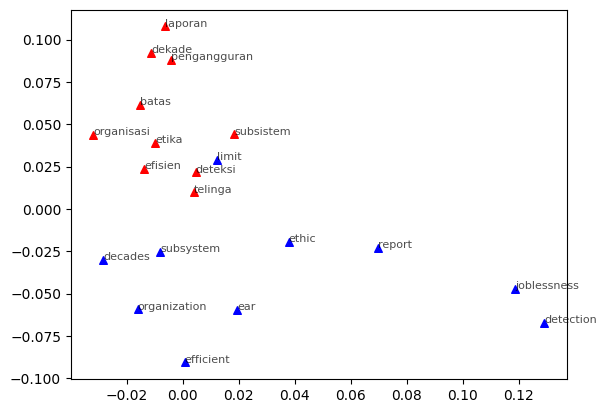

In [ ]:
MAX_WORDS_TO_DISPLAY = 10

def plot_bilingual_embeddings(embeddings1, embeddings2, selected_words):
  count_words_displayed = 0
  for en_word, id_word in selected_words:
      word = en_word
      coord = embeddings1[word]
      plt.scatter(coord[0], coord[1], color='blue', marker='^', s=30, label='English' if count_words_displayed == 0 else None)
      plt.annotate(word, (coord[0], coord[1]), fontsize=8, alpha=0.7)

      word = id_word
      coord = embeddings2[word]
      plt.scatter(coord[0], coord[1], color='red', marker='^', s=30, label='Indonesian' if count_words_displayed == 0 else None)
      plt.annotate(word, (coord[0], coord[1]), fontsize=8, alpha=0.7)
      count_words_displayed += 1

plot_bilingual_embeddings(ori_en_word_norm_embeddings, ori_id_word_norm_embeddings, en_id_test[:MAX_WORDS_TO_DISPLAY])

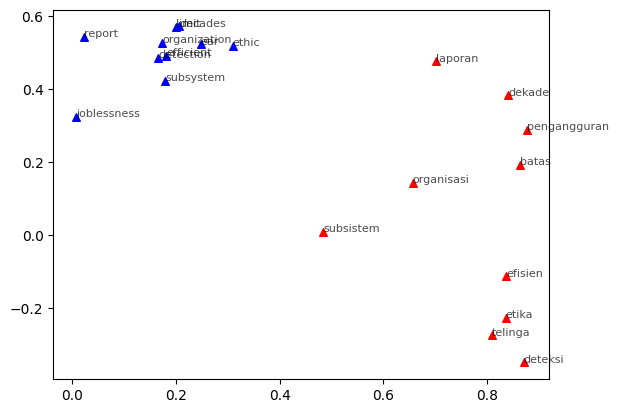

In [ ]:
plot_bilingual_embeddings(unsup_en_word_embeddings, unsup_id_word_embeddings, en_id_test[:MAX_WORDS_TO_DISPLAY])

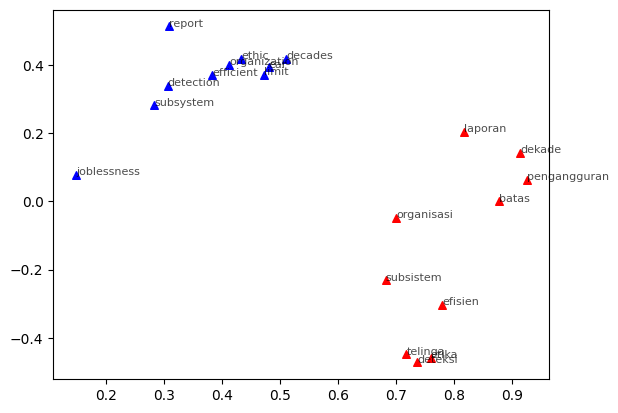

In [ ]:
plot_bilingual_embeddings(semisup_num_en_word_embeddings, semisup_num_id_word_embeddings, en_id_test[:MAX_WORDS_TO_DISPLAY])

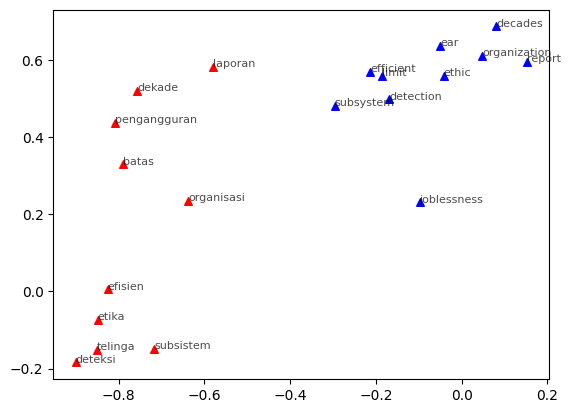

In [ ]:
plot_bilingual_embeddings(semisup_27_en_word_embeddings, semisup_27_id_word_embeddings, en_id_test[:MAX_WORDS_TO_DISPLAY])

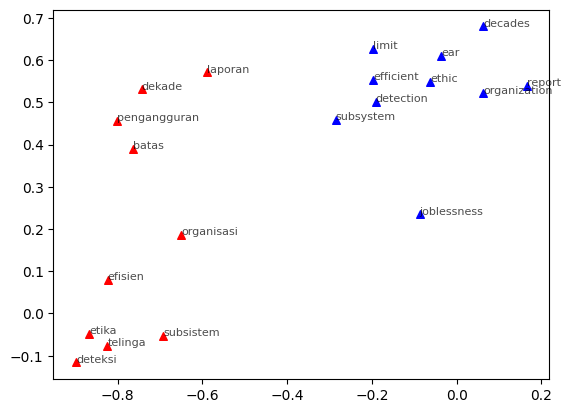

In [ ]:
plot_bilingual_embeddings(semisup_1500_en_word_embeddings, semisup_1500_id_word_embeddings, en_id_test[:MAX_WORDS_TO_DISPLAY])

# Fasttext (better than Word2Vec)

## 1. Download Fasttext The Pre-Train Word Vectors for Languages (Run Once - Done. Not Used)

source: [link](https://fasttext.cc/docs/en/crawl-vectors.html)

In [ ]:
# fasttext.util.download_model('en', if_exists='ignore')  # English
# ft_en = fasttext.load_model('cc.en.300.bin')

In [ ]:
# !cp "cc.en.300.bin" "$FASTTEXT_PATH"

In [ ]:
# fasttext.util.download_model('id', if_exists='ignore')  # Indonesia
# ft_id = fasttext.load_model('cc.id.300.bin')

In [ ]:
# !cp "cc.id.300.bin" "$FASTTEXT_PATH"

## 2. Load The Word Vectors Models & Save it In Word2Vec Format (Run Once - Done. Not Used)

reference:
- [link](https://github.com/facebookresearch/fastText)
- [link2](https://datascience.stackexchange.com/questions/20071/how-do-i-load-fasttext-pretrained-model-with-gensim)

In [ ]:
from gensim.models import FastText

In [ ]:
# ft_en = FastText.load(os.path.join(FASTTEXT_PATH, 'cc.en.300.bin'))
# ft_id = FastText.load(os.path.join(FASTTEXT_PATH, 'cc.id.300.bin'))
# ft_nah = fasttext.load_model(os.path.join(FASTTEXT_PATH, 'cc.nah.300.bin'))
# ft_es = fasttext.load_model(os.path.join(FASTTEXT_PATH, 'cc.es.300.bin'))

In [ ]:
from gensim.models.fasttext import load_facebook_model

# ft_en_wv = load_facebook_model(os.path.join(FASTTEXT_PATH, 'cc.en.300.bin'))
# ft_id_wv = load_facebook_model(os.path.join(FASTTEXT_PATH, 'cc.id.300.bin'))

In [ ]:
# ft_en_wv.wv.save_word2vec_format(PRETRAINED_FT_EN_EMB_PATH, binary=False)
# ft_id_wv.wv.save_word2vec_format(PRETRAINED_FT_ID_EMB_PATH, binary=False)

## 3. Train (Run Once - Done)

In [ ]:
# en_text = []
# id_text = []

# # english corpus
# with open(os.path.join(CORPUS_EN_ID_PATH,'News-Commentary.en-id.en')) as f:
#   en_text += [sent.strip() for sent in f.readlines()] # parallel data (en-id)
# with open(os.path.join(CORPUS_EN_ID_PATH,'wikimedia.en')) as f:
#   en_text += [sent.strip() for sent in f.readlines()] # mono data (en-id)

# with open(os.path.join(CORPUS_EN_ID_PATH,'News-Commentary.en-id.id')) as f:
#   id_text += [sent.strip() for sent in f.readlines()] # parallel data (en-id)
# with open(os.path.join(CORPUS_EN_ID_PATH,'wikimedia.id')) as f:
#   id_text += [sent.strip() for sent in f.readlines()] # mono data (en-id)

  18054  376873 2460800 /content/drive/MyDrive/Colab Notebooks/Machine Translation and Multilingualism/MT Final Project/Data/corpus/en-id/News-Commentary.en-id.en
  18987630  431427780 2766103752 /content/drive/MyDrive/Colab Notebooks/Machine Translation and Multilingualism/MT Final Project/Data/corpus/en-id/wikimedia.en
  18054  373842 2847797 /content/drive/MyDrive/Colab Notebooks/Machine Translation and Multilingualism/MT Final Project/Data/corpus/en-id/News-Commentary.en-id.id
  453709  8426567 60583872 /content/drive/MyDrive/Colab Notebooks/Machine Translation and Multilingualism/MT Final Project/Data/corpus/en-id/wikimedia.id


In [ ]:
!cat "/content/drive/MyDrive/Colab Notebooks/Machine Translation and Multilingualism/MT Final Project/Data/corpus/en-id/News-Commentary.en-id.en" "/content/drive/MyDrive/Colab Notebooks/Machine Translation and Multilingualism/MT Final Project/Data/corpus/en-id/wikimedia.en" > "temp.en"
!cat "/content/drive/MyDrive/Colab Notebooks/Machine Translation and Multilingualism/MT Final Project/Data/corpus/en-id/News-Commentary.en-id.id" "/content/drive/MyDrive/Colab Notebooks/Machine Translation and Multilingualism/MT Final Project/Data/corpus/en-id/wikimedia.id" > "temp.id"

In [ ]:
!wc "temp.en"
!wc "temp.id"

  19005684  431804653 2768564552 temp.en
  471763  8800409 63431669 temp.id


In [ ]:
# Path to your corpus file
corpus_file = "temp.en"

model = fasttext.train_unsupervised(corpus_file,dim=100, minCount=5)
# Save the trained model
# model.save_model(os.path.join(FASTTEXT_PATH, 'scratch.en.bin'))

In [ ]:
# Path to your corpus file
corpus_file = "temp.id"

model = fasttext.train_unsupervised(corpus_file,dim=100, minCount=5)
# Save the trained model
# model.save_model(os.path.join(FASTTEXT_PATH, 'scratch.id.bin'))

In [ ]:
from gensim.models.fasttext import load_facebook_model

ft_en_wv = load_facebook_model(os.path.join(FASTTEXT_PATH, 'scratch.en.bin'))
ft_id_wv = load_facebook_model(os.path.join(FASTTEXT_PATH, 'scratch.id.bin'))

ft_en_wv.wv.save_word2vec_format(FT_EN_EMB_PATH, binary=False)
ft_id_wv.wv.save_word2vec_format(FT_ID_EMB_PATH, binary=False)

## 4. Create the Seed Dictionary

In [ ]:
from gensim.models import KeyedVectors

# Load the Word2Vec model
# word2vec_model = KeyedVectors.load_word2vec_format(embedding_file, binary=True)

en_loaded_model = KeyedVectors.load_word2vec_format(FT_EN_EMB_PATH, binary=False)
id_loaded_model = KeyedVectors.load_word2vec_format(FT_ID_EMB_PATH, binary=False)

In [ ]:
# Get the vocabulary list
en_vocab = list(en_loaded_model.index_to_key)
id_vocab = list(id_loaded_model.index_to_key)

In [ ]:
# with open(os.path.join(EMBEDDING_PATH, "vocab.en"), "w") as f:
#   for vocab in en_vocab:
#     f.write(vocab + "\n")

# with open(os.path.join(EMBEDDING_PATH, "vocab.id"), "w") as f:
#   for vocab in id_vocab:
#     f.write(vocab + "\n")

### 4.1. Numeral Dictionary

In [ ]:
!cat "/content/drive/MyDrive/Colab Notebooks/Machine Translation and Multilingualism/MT Final Project/Data/corpus/en-id/News-Commentary.en-id.en" "/content/drive/MyDrive/Colab Notebooks/Machine Translation and Multilingualism/MT Final Project/Data/corpus/en-id/wikimedia.en" > "temp.en"
!cat "/content/drive/MyDrive/Colab Notebooks/Machine Translation and Multilingualism/MT Final Project/Data/corpus/en-id/News-Commentary.en-id.id" "/content/drive/MyDrive/Colab Notebooks/Machine Translation and Multilingualism/MT Final Project/Data/corpus/en-id/wikimedia.id" > "temp.id"

In [ ]:
NUMERAL_PATTERN = re.compile(r"^[0-9]+$")

def subset_values(list1, list2):
    return [x for x in list1 if x in list2]

numerals_en = [vocab for vocab in en_vocab if NUMERAL_PATTERN.match(vocab)]
numerals_id = [vocab for vocab in id_vocab if NUMERAL_PATTERN.match(vocab)]

numerals_en = sorted(numerals_en)
numerals_id = sorted(numerals_id)
numerals_en_id = subset_values(numerals_en, numerals_id)

In [ ]:
with open("temp.en") as f:
  en_text = "".join(f.readlines())

with open("temp.id") as f:
  id_text = "".join(f.readlines())

In [ ]:
indices = []
for idx, number in enumerate(numerals_en_id):
  if number not in en_text or number not in id_text:
    indices.append(idx)

# Remove items at the specified indices
for index in sorted(indices, reverse=True):
    del numerals_en_id[index]

In [ ]:
len(indices)

0

In [ ]:
# with open(EN_ID_TRAIN_NUMERAL_DICT_PATH, "w") as f:
#   for number in numerals_en_id:
#     f.write(number + " " + number + "\n")

## 5. Create the Mapping

if you encounter this problem while running:
```
ERROR: Install CuPy for CUDA support
```
maybe you forgot to use GPU

In [ ]:
!python3 "vecmap/map_embeddings.py" --unsupervised "$FT_EN_EMB_PATH" "$FT_ID_EMB_PATH" "$UNSUP_MAPPED_ENID_EN_EMB_PATH" "$UNSUP_MAPPED_ENID_ID_EMB_PATH" --cuda

In [ ]:
!python3 "vecmap/map_embeddings.py" --semi_supervised "$EN_ID_TRAIN_NUMERAL_DICT_PATH" "$FT_EN_EMB_PATH" "$FT_ID_EMB_PATH" "$SEMISUP_NUMERAL_MAPPED_ENID_EN_EMB_PATH" "$SEMISUP_NUMERAL_MAPPED_ENID_ID_EMB_PATH" --cuda

the warning is probably because of the 'value' that we set, minCount=5. these OOV occured < 5

In [ ]:
!python3 "vecmap/map_embeddings.py" --semi_supervised "$EN_ID_TRAIN_27_DICT_PATH" "$FT_EN_EMB_PATH" "$FT_ID_EMB_PATH" "$SEMISUP_27_MAPPED_ENID_EN_EMB_PATH" "$SEMISUP_27_MAPPED_ENID_ID_EMB_PATH" --cuda

In [ ]:
!python3 "vecmap/map_embeddings.py" --semi_supervised "$EN_ID_TRAIN_1500_DICT_PATH" "$FT_EN_EMB_PATH" "$FT_ID_EMB_PATH" "$SEMISUP_1500_MAPPED_ENID_EN_EMB_PATH" "$SEMISUP_1500_MAPPED_ENID_ID_EMB_PATH" --cuda

## 6. Evaluation

In [ ]:
!python3 "vecmap/eval_translation.py" "$UNSUP_MAPPED_ENID_EN_EMB_PATH" "$UNSUP_MAPPED_ENID_ID_EMB_PATH" -d "$EN_ID_TEST_DICT_PATH"
!python3 "vecmap/eval_translation.py" "$UNSUP_MAPPED_ENID_EN_EMB_PATH" "$UNSUP_MAPPED_ENID_ID_EMB_PATH" -d "$EN_ID_TEST_DICT_PATH" --retrieval csls

Coverage: 94.55%  Accuracy: 47.92%
Coverage: 94.55%  Accuracy: 47.12%


In [ ]:
!python3 "vecmap/eval_translation.py" "$SEMISUP_NUMERAL_MAPPED_ENID_EN_EMB_PATH" "$SEMISUP_NUMERAL_MAPPED_ENID_ID_EMB_PATH" -d "$EN_ID_TEST_DICT_PATH"
!python3 "vecmap/eval_translation.py" "$SEMISUP_NUMERAL_MAPPED_ENID_EN_EMB_PATH" "$SEMISUP_NUMERAL_MAPPED_ENID_ID_EMB_PATH" -d "$EN_ID_TEST_DICT_PATH" --retrieval csls

Coverage: 94.55%  Accuracy: 47.28%
Coverage: 94.55%  Accuracy: 47.44%


In [ ]:
!python3 "vecmap/eval_translation.py" "$SEMISUP_27_MAPPED_ENID_EN_EMB_PATH" "$SEMISUP_27_MAPPED_ENID_ID_EMB_PATH" -d "$EN_ID_TEST_DICT_PATH"
!python3 "vecmap/eval_translation.py" "$SEMISUP_27_MAPPED_ENID_EN_EMB_PATH" "$SEMISUP_27_MAPPED_ENID_ID_EMB_PATH" -d "$EN_ID_TEST_DICT_PATH" --retrieval csls

Coverage: 94.55%  Accuracy: 47.12%
Coverage: 94.55%  Accuracy: 47.44%


In [ ]:
!python3 "vecmap/eval_translation.py" "$SEMISUP_1500_MAPPED_ENID_EN_EMB_PATH" "$SEMISUP_1500_MAPPED_ENID_ID_EMB_PATH" -d "$EN_ID_TEST_DICT_PATH"
!python3 "vecmap/eval_translation.py" "$SEMISUP_1500_MAPPED_ENID_EN_EMB_PATH" "$SEMISUP_1500_MAPPED_ENID_ID_EMB_PATH" -d "$EN_ID_TEST_DICT_PATH" --retrieval csls

Coverage: 94.55%  Accuracy: 47.12%
Coverage: 94.55%  Accuracy: 47.44%


## 7. Plot

In [13]:
from gensim.models import KeyedVectors

# Load the word embeddings
ori_en_word_vectors = KeyedVectors.load_word2vec_format(FT_EN_EMB_PATH, binary=False)
ori_id_word_vectors = KeyedVectors.load_word2vec_format(FT_ID_EMB_PATH, binary=False)

In [14]:
unsup_en_word_vectors = KeyedVectors.load_word2vec_format(UNSUP_MAPPED_ENID_EN_EMB_PATH, binary=False)
unsup_id_word_vectors = KeyedVectors.load_word2vec_format(UNSUP_MAPPED_ENID_ID_EMB_PATH, binary=False)

In [15]:
semisup_num_en_word_vectors = KeyedVectors.load_word2vec_format(SEMISUP_NUMERAL_MAPPED_ENID_EN_EMB_PATH, binary=False)
semisup_num_id_word_vectors = KeyedVectors.load_word2vec_format(SEMISUP_NUMERAL_MAPPED_ENID_ID_EMB_PATH, binary=False)

In [16]:
semisup_27_en_word_vectors = KeyedVectors.load_word2vec_format(SEMISUP_27_MAPPED_ENID_EN_EMB_PATH, binary=False)
semisup_27_id_word_vectors = KeyedVectors.load_word2vec_format(SEMISUP_27_MAPPED_ENID_ID_EMB_PATH, binary=False)

In [17]:
semisup_1500_en_word_vectors = KeyedVectors.load_word2vec_format(SEMISUP_1500_MAPPED_ENID_EN_EMB_PATH, binary=False)
semisup_1500_id_word_vectors = KeyedVectors.load_word2vec_format(SEMISUP_1500_MAPPED_ENID_ID_EMB_PATH, binary=False)

In [18]:
ori_en_word_embeddings = {word: ori_en_word_vectors[word] for word in ori_en_word_vectors.index_to_key}
ori_id_word_embeddings = {word: ori_id_word_vectors[word] for word in ori_id_word_vectors.index_to_key}

unsup_en_word_embeddings = {word: unsup_en_word_vectors[word] for word in unsup_en_word_vectors.index_to_key}
unsup_id_word_embeddings = {word: unsup_id_word_vectors[word] for word in unsup_id_word_vectors.index_to_key}

semisup_num_en_word_embeddings = {word: semisup_num_en_word_vectors[word] for word in semisup_num_en_word_vectors.index_to_key}
semisup_num_id_word_embeddings = {word: semisup_num_id_word_vectors[word] for word in semisup_num_id_word_vectors.index_to_key}

semisup_27_en_word_embeddings = {word: semisup_27_en_word_vectors[word] for word in semisup_27_en_word_vectors.index_to_key}
semisup_27_id_word_embeddings = {word: semisup_27_id_word_vectors[word] for word in semisup_27_id_word_vectors.index_to_key}

semisup_1500_en_word_embeddings = {word: semisup_1500_en_word_vectors[word] for word in semisup_1500_en_word_vectors.index_to_key}
semisup_1500_id_word_embeddings = {word: semisup_1500_id_word_vectors[word] for word in semisup_1500_id_word_vectors.index_to_key}

In [19]:
import numpy as np

def normalized_embeddings(word_embeddings):
  # Normalize the word embeddings
  word_embeddings_normalized = {}
  for word, embedding in word_embeddings.items():
      normalized_embedding = embedding / np.linalg.norm(embedding)
      word_embeddings_normalized[word] = normalized_embedding

  return word_embeddings_normalized

ori_en_word_norm_embeddings = normalized_embeddings(ori_en_word_embeddings)
ori_id_word_norm_embeddings = normalized_embeddings(ori_id_word_embeddings)

unsup_en_word_norm_embeddings = normalized_embeddings(unsup_en_word_embeddings)
unsup_id_word_norm_embeddings = normalized_embeddings(unsup_id_word_embeddings)

semisup_num_en_word_norm_embeddings = normalized_embeddings(semisup_num_en_word_embeddings)
semisup_num_id_word_norm_embeddings = normalized_embeddings(semisup_num_id_word_embeddings)

semisup_27_en_word_norm_embeddings = normalized_embeddings(semisup_27_en_word_embeddings)
semisup_27_id_word_norm_embeddings = normalized_embeddings(semisup_27_id_word_embeddings)

semisup_1500_en_word_norm_embeddings = normalized_embeddings(semisup_1500_en_word_embeddings)
semisup_1500_id_word_norm_embeddings = normalized_embeddings(semisup_1500_id_word_embeddings)

In [20]:
with open(EN_ID_TEST_DICT_PATH) as f:
  en_id_test = [line.strip().split() for line in f.readlines()]

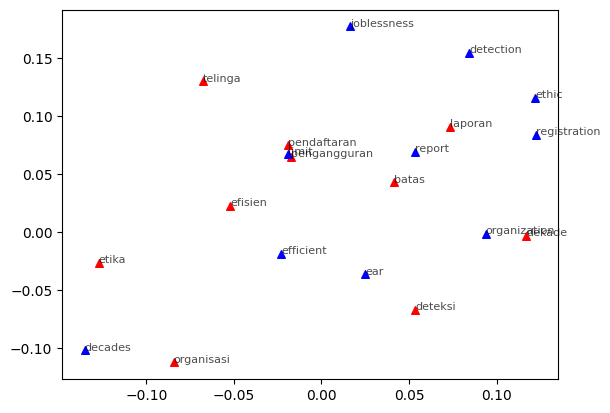

In [21]:
MAX_WORDS_TO_DISPLAY = 10

def plot_bilingual_embeddings(embeddings1, embeddings2, selected_words):
  count_words_displayed = 0
  for en_word, id_word in selected_words:
      if en_word in embeddings1 and id_word in embeddings2:
        count_words_displayed += 1
      else:
        continue
      word = en_word
      coord = embeddings1[word]
      plt.scatter(coord[0], coord[1], color='blue', marker='^', s=30, label='English' if count_words_displayed == 0 else None)
      plt.annotate(word, (coord[0], coord[1]), fontsize=8, alpha=0.7)

      word = id_word
      coord = embeddings2[word]
      plt.scatter(coord[0], coord[1], color='red', marker='^', s=30, label='Indonesian' if count_words_displayed == 0 else None)
      plt.annotate(word, (coord[0], coord[1]), fontsize=8, alpha=0.7)
      if count_words_displayed == MAX_WORDS_TO_DISPLAY:
        break

plot_bilingual_embeddings(ori_en_word_norm_embeddings, ori_id_word_norm_embeddings, en_id_test)

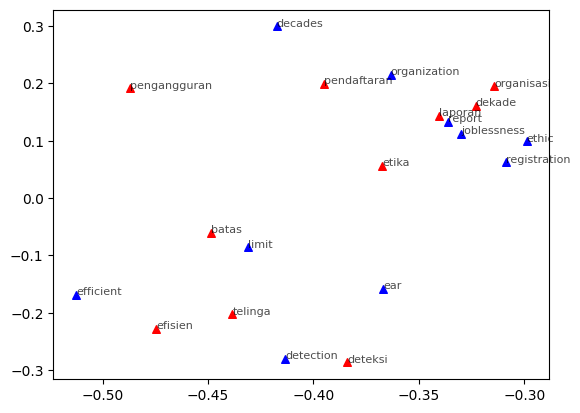

In [22]:
plot_bilingual_embeddings(unsup_en_word_embeddings, unsup_id_word_embeddings, en_id_test)

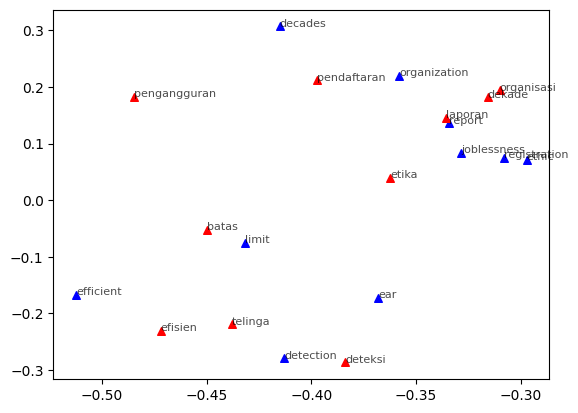

In [23]:
plot_bilingual_embeddings(semisup_num_en_word_embeddings, semisup_num_id_word_embeddings, en_id_test)

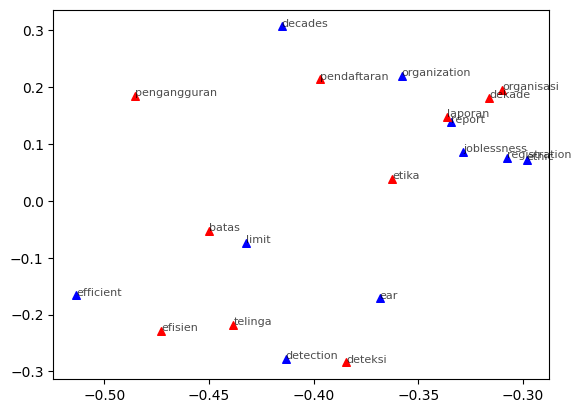

In [24]:
plot_bilingual_embeddings(semisup_27_en_word_embeddings, semisup_27_id_word_embeddings, en_id_test)

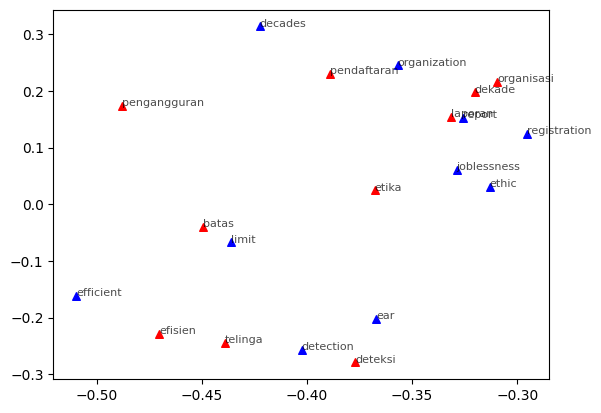

In [25]:
plot_bilingual_embeddings(semisup_1500_en_word_embeddings, semisup_1500_id_word_embeddings, en_id_test)

# Fasttext, is it really good?

we have a quite good performance using fasttext embedding. but let's analyze this a little bit closer. we are curious on how is the performance on words based on the frequencies.

## 1. Create the Test Set based on Frequency

In [ ]:
with open(EN_ID_TEST_DICT_PATH) as f:
  en_id_tuples = [line.strip().split() for line in f.readlines()]

In [ ]:
en_id_tuples[0]

['organization', 'organisasi']

In [ ]:
!cat "/content/drive/MyDrive/Colab Notebooks/Machine Translation and Multilingualism/MT Final Project/Data/corpus/en-id/News-Commentary.en-id.en" "/content/drive/MyDrive/Colab Notebooks/Machine Translation and Multilingualism/MT Final Project/Data/corpus/en-id/wikimedia.en" > "temp.en"
!cat "/content/drive/MyDrive/Colab Notebooks/Machine Translation and Multilingualism/MT Final Project/Data/corpus/en-id/News-Commentary.en-id.id" "/content/drive/MyDrive/Colab Notebooks/Machine Translation and Multilingualism/MT Final Project/Data/corpus/en-id/wikimedia.id" > "temp.id"

In [ ]:
with open("temp.en") as f:
  # en_text = "".join(f.readlines())
  en_lines = [line.strip() for line in f.readlines()]

with open("temp.id") as f:
  # id_text = "".join(f.readlines())
  id_lines = [line.strip() for line in f.readlines()]

In [ ]:
test_id_words = [word for _, word in en_id_tuples]
test_en_words = [word for word, _ in en_id_tuples]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer
en_vectorizer = CountVectorizer()

# Fit the vectorizer on the corpus and transform the corpus into a document-term matrix
X_en = en_vectorizer.fit_transform(en_lines)

# Get the feature names (i.e., the words)
en_words = en_vectorizer.get_feature_names_out()

# Get the total occurrence of each word
en_word_occurrences = X_en.sum(axis=0)
en_dense_word_occurrences = en_word_occurrences.A1

In [ ]:
# Initialize CountVectorizer
id_vectorizer = CountVectorizer()

# Fit the vectorizer on the corpus and transform the corpus into a document-term matrix
X_id = id_vectorizer.fit_transform(id_lines)

# Get the feature names (i.e., the words)
id_words = id_vectorizer.get_feature_names_out()

# Get the total occurrence of each word
id_word_occurrences = X_id.sum(axis=0)
id_dense_word_occurrences = id_word_occurrences.A1

In [ ]:
# Print word occurrences
for word, idx in en_vectorizer.vocabulary_.items():
    print(f"'{word}' occurs {en_word_occurrences[0, idx]} times.")
    break

for word, count in zip(en_words, en_dense_word_occurrences):
    print(f"'{word}' occurs {count} times.")
    break

'closing' occurs 8103 times.
'00' occurs 43995 times.


In [ ]:
# Print word occurrences
for word, idx in id_vectorizer.vocabulary_.items():
    print(f"'{word}' occurs {id_word_occurrences[0, idx]} times.")
    break

for word, count in zip(id_words, id_dense_word_occurrences):
    print(f"'{word}' occurs {count} times.")
    break

'mengurangi' occurs 1405 times.
'00' occurs 984 times.


In [ ]:
type(en_word_occurrences[0, idx])

numpy.int64

In [ ]:
test_en_occurences_dict = {}
test_id_occurences_dict = {}
for word, idx in en_vectorizer.vocabulary_.items():
    if word in test_en_words:
      test_en_occurences_dict[word] = en_word_occurrences[0, idx]

for word, idx in id_vectorizer.vocabulary_.items():
    if word in test_id_words:
      test_id_occurences_dict[word] = id_word_occurrences[0, idx]

In [ ]:
max(test_en_occurences_dict.values())

427349

In [ ]:
max(test_id_occurences_dict.values())

16587

In [ ]:
LOW_FREQ = 100
HIGH_FREQ = 5000

In [ ]:
low_freq_words = []
mid_freq_words = []
high_freq_words = []

In [ ]:
for en_word, id_word in en_id_tuples:
  tup = (en_word, id_word)
  en_oc = test_en_occurences_dict[en_word]
  id_oc = test_id_occurences_dict[id_word]

  if en_oc <= LOW_FREQ or id_oc <= LOW_FREQ:
    low_freq_words.append(tup)
  elif en_oc >= HIGH_FREQ and id_oc >= HIGH_FREQ:
    high_freq_words.append(tup)
  else:
    mid_freq_words.append(tup)

In [ ]:
len(low_freq_words), len(mid_freq_words), len(high_freq_words)

(139, 506, 15)

In [ ]:
EN_ID_TEST_LOW_FREQ_DICT_PATH = os.path.join(TRAIN_TEST_PATH,'test_low_freq.en-id.dict')
EN_ID_TEST_MID_FREQ_DICT_PATH = os.path.join(TRAIN_TEST_PATH,'test_mid_freq.en-id.dict')
EN_ID_TEST_HIGH_FREQ_DICT_PATH = os.path.join(TRAIN_TEST_PATH,'test_high_freq.en-id.dict')

In [ ]:
# with open(EN_ID_TEST_LOW_FREQ_DICT_PATH, "w") as f:
#   for en_word, id_word in low_freq_words:
#     f.write(en_word + " " + id_word + "\n")

# with open(EN_ID_TEST_MID_FREQ_DICT_PATH, "w") as f:
#   for en_word, id_word in mid_freq_words:
#     f.write(en_word + " " + id_word + "\n")

# with open(EN_ID_TEST_HIGH_FREQ_DICT_PATH, "w") as f:
#   for en_word, id_word in high_freq_words:
#     f.write(en_word + " " + id_word + "\n")

## 2. Evaluation

unsupervised

In [ ]:
!python3 "vecmap/eval_translation.py" "$UNSUP_MAPPED_ENID_EN_EMB_PATH" "$UNSUP_MAPPED_ENID_ID_EMB_PATH" -d "$EN_ID_TEST_LOW_FREQ_DICT_PATH"
!python3 "vecmap/eval_translation.py" "$UNSUP_MAPPED_ENID_EN_EMB_PATH" "$UNSUP_MAPPED_ENID_ID_EMB_PATH" -d "$EN_ID_TEST_LOW_FREQ_DICT_PATH" --retrieval csls

Coverage: 88.49%  Accuracy: 17.89%
Coverage: 88.49%  Accuracy: 23.58%


In [ ]:
!python3 "vecmap/eval_translation.py" "$UNSUP_MAPPED_ENID_EN_EMB_PATH" "$UNSUP_MAPPED_ENID_ID_EMB_PATH" -d "$EN_ID_TEST_MID_FREQ_DICT_PATH"
!python3 "vecmap/eval_translation.py" "$UNSUP_MAPPED_ENID_EN_EMB_PATH" "$UNSUP_MAPPED_ENID_ID_EMB_PATH" -d "$EN_ID_TEST_MID_FREQ_DICT_PATH" --retrieval csls

Coverage: 96.05%  Accuracy: 56.17%
Coverage: 96.05%  Accuracy: 53.91%


In [ ]:
!python3 "vecmap/eval_translation.py" "$UNSUP_MAPPED_ENID_EN_EMB_PATH" "$UNSUP_MAPPED_ENID_ID_EMB_PATH" -d "$EN_ID_TEST_HIGH_FREQ_DICT_PATH"
!python3 "vecmap/eval_translation.py" "$UNSUP_MAPPED_ENID_EN_EMB_PATH" "$UNSUP_MAPPED_ENID_ID_EMB_PATH" -d "$EN_ID_TEST_HIGH_FREQ_DICT_PATH" --retrieval csls

Coverage:100.00%  Accuracy: 26.67%
Coverage:100.00%  Accuracy: 20.00%


semi-supervised numeral

In [ ]:
!python3 "vecmap/eval_translation.py" "$SEMISUP_NUMERAL_MAPPED_ENID_EN_EMB_PATH" "$SEMISUP_NUMERAL_MAPPED_ENID_ID_EMB_PATH" -d "$EN_ID_TEST_LOW_FREQ_DICT_PATH"
!python3 "vecmap/eval_translation.py" "$SEMISUP_NUMERAL_MAPPED_ENID_EN_EMB_PATH" "$SEMISUP_NUMERAL_MAPPED_ENID_ID_EMB_PATH" -d "$EN_ID_TEST_LOW_FREQ_DICT_PATH" --retrieval csls

Coverage: 88.49%  Accuracy: 18.70%
Coverage: 88.49%  Accuracy: 23.58%


In [ ]:
!python3 "vecmap/eval_translation.py" "$SEMISUP_NUMERAL_MAPPED_ENID_EN_EMB_PATH" "$SEMISUP_NUMERAL_MAPPED_ENID_ID_EMB_PATH" -d "$EN_ID_TEST_MID_FREQ_DICT_PATH"
!python3 "vecmap/eval_translation.py" "$SEMISUP_NUMERAL_MAPPED_ENID_EN_EMB_PATH" "$SEMISUP_NUMERAL_MAPPED_ENID_ID_EMB_PATH" -d "$EN_ID_TEST_MID_FREQ_DICT_PATH" --retrieval csls

Coverage: 96.05%  Accuracy: 55.14%
Coverage: 96.05%  Accuracy: 54.32%


In [ ]:
!python3 "vecmap/eval_translation.py" "$SEMISUP_NUMERAL_MAPPED_ENID_EN_EMB_PATH" "$SEMISUP_NUMERAL_MAPPED_ENID_ID_EMB_PATH" -d "$EN_ID_TEST_HIGH_FREQ_DICT_PATH"
!python3 "vecmap/eval_translation.py" "$SEMISUP_NUMERAL_MAPPED_ENID_EN_EMB_PATH" "$SEMISUP_NUMERAL_MAPPED_ENID_ID_EMB_PATH" -d "$EN_ID_TEST_HIGH_FREQ_DICT_PATH" --retrieval csls

Coverage:100.00%  Accuracy: 26.67%
Coverage:100.00%  Accuracy: 20.00%


semi-supervised small seed

In [ ]:
!python3 "vecmap/eval_translation.py" "$SEMISUP_27_MAPPED_ENID_EN_EMB_PATH" "$SEMISUP_27_MAPPED_ENID_ID_EMB_PATH" -d "$EN_ID_TEST_LOW_FREQ_DICT_PATH"
!python3 "vecmap/eval_translation.py" "$SEMISUP_27_MAPPED_ENID_EN_EMB_PATH" "$SEMISUP_27_MAPPED_ENID_ID_EMB_PATH" -d "$EN_ID_TEST_LOW_FREQ_DICT_PATH" --retrieval csls

Coverage: 88.49%  Accuracy: 17.89%
Coverage: 88.49%  Accuracy: 23.58%


In [ ]:
!python3 "vecmap/eval_translation.py" "$SEMISUP_27_MAPPED_ENID_EN_EMB_PATH" "$SEMISUP_27_MAPPED_ENID_ID_EMB_PATH" -d "$EN_ID_TEST_MID_FREQ_DICT_PATH"
!python3 "vecmap/eval_translation.py" "$SEMISUP_27_MAPPED_ENID_EN_EMB_PATH" "$SEMISUP_27_MAPPED_ENID_ID_EMB_PATH" -d "$EN_ID_TEST_MID_FREQ_DICT_PATH" --retrieval csls

Coverage: 96.05%  Accuracy: 55.14%
Coverage: 96.05%  Accuracy: 54.32%


In [ ]:
!python3 "vecmap/eval_translation.py" "$SEMISUP_27_MAPPED_ENID_EN_EMB_PATH" "$SEMISUP_27_MAPPED_ENID_ID_EMB_PATH" -d "$EN_ID_TEST_HIGH_FREQ_DICT_PATH"
!python3 "vecmap/eval_translation.py" "$SEMISUP_27_MAPPED_ENID_EN_EMB_PATH" "$SEMISUP_27_MAPPED_ENID_ID_EMB_PATH" -d "$EN_ID_TEST_HIGH_FREQ_DICT_PATH" --retrieval csls

Coverage:100.00%  Accuracy: 26.67%
Coverage:100.00%  Accuracy: 20.00%


semi-supervised higher seed

In [ ]:
!python3 "vecmap/eval_translation.py" "$SEMISUP_1500_MAPPED_ENID_EN_EMB_PATH" "$SEMISUP_1500_MAPPED_ENID_ID_EMB_PATH" -d "$EN_ID_TEST_LOW_FREQ_DICT_PATH"
!python3 "vecmap/eval_translation.py" "$SEMISUP_1500_MAPPED_ENID_EN_EMB_PATH" "$SEMISUP_1500_MAPPED_ENID_ID_EMB_PATH" -d "$EN_ID_TEST_LOW_FREQ_DICT_PATH" --retrieval csls

Coverage: 88.49%  Accuracy: 18.70%
Coverage: 88.49%  Accuracy: 23.58%


In [ ]:
!python3 "vecmap/eval_translation.py" "$SEMISUP_1500_MAPPED_ENID_EN_EMB_PATH" "$SEMISUP_1500_MAPPED_ENID_ID_EMB_PATH" -d "$EN_ID_TEST_MID_FREQ_DICT_PATH"
!python3 "vecmap/eval_translation.py" "$SEMISUP_1500_MAPPED_ENID_EN_EMB_PATH" "$SEMISUP_1500_MAPPED_ENID_ID_EMB_PATH" -d "$EN_ID_TEST_MID_FREQ_DICT_PATH" --retrieval csls

Coverage: 96.05%  Accuracy: 55.14%
Coverage: 96.05%  Accuracy: 54.32%


In [ ]:
!python3 "vecmap/eval_translation.py" "$SEMISUP_1500_MAPPED_ENID_EN_EMB_PATH" "$SEMISUP_1500_MAPPED_ENID_ID_EMB_PATH" -d "$EN_ID_TEST_HIGH_FREQ_DICT_PATH"
!python3 "vecmap/eval_translation.py" "$SEMISUP_1500_MAPPED_ENID_EN_EMB_PATH" "$SEMISUP_1500_MAPPED_ENID_ID_EMB_PATH" -d "$EN_ID_TEST_HIGH_FREQ_DICT_PATH" --retrieval csls

Coverage:100.00%  Accuracy: 20.00%
Coverage:100.00%  Accuracy: 20.00%
